# 导包

In [1]:
#导包
from tensorflow.keras import layers, models
from tensorflow.keras.layers import ConvLSTM2D,LSTM, BatchNormalization, LayerNormalization,Input, Conv3D, TimeDistributed, Flatten
from tensorflow.keras.layers import Concatenate,Conv2D,TimeDistributed, MaxPooling2D, Input, MaxPooling3D
from tensorflow.keras.layers import  Reshape,Multiply
from tensorflow.keras.layers import Layer,Lambda,Dot,ReLU, Dense, Dropout, Activation, Flatten,Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import r2_score,accuracy_score,precision_score
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras import regularizers
import tensorflow as tf
from datetime import datetime
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from tensorflow.keras import models, layers
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.keras as keras
from tensorflow.keras import layers, Sequential, regularizers
# calculate RMSE
from tensorflow.keras.losses import MeanSquaredError
from math import sqrt
import pandas as pd 
import tensorflow as tf
import gc 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import os 
# from model import create_model
from evaluate import look_loss
from evaluate import all_estimate

gc.collect()

2025-08-14 16:17:53.197407: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 16:17:54.337230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755159474.760134    8835 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755159474.854990    8835 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755159475.739992    8835 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

23

# 数据处理

In [2]:
depth = [5.1, 18.5, 40.3, 65.8, 77.9, 92.3, 109.7, 130.7, 155.9, 186.1, 222.5, 266.0, 318.1, 380.2, 453.9, 541.1, 643.6, 763.3, 902.3, 1062.4]
data_st_processed = np.load(r'./data_st_processed.npy')
data_surface_processed = np.load(r'./data_surface_processed.npy')
data_surface = data_surface_processed[0:132,0:200,0:300,:]

data_input = data_surface

data_st = data_st_processed[:,0:200,0:300,:]

print(data_surface.shape,data_st.shape)

out_data_y = data_st_processed[:,:,:,0:1] #(132,  100，160， 1)
print(out_data_y.shape)

(132, 108, 168, 5) (132, 100, 160, 20)
(132, 100, 160, 1)


In [3]:
print('----------------for layer1_ST--------------------')

time_size, lat_size, lon_size, channel = data_input.shape   # （132，120，120，5）
#print( time_size, lat_size, lon_size,channel)
# 定义矩形框的大小和步幅           
box_size = 9  # 单位为度
step_size = 1  # 滑动步幅

# 计算输出网格的形状
out_lat_size = (lat_size - box_size + 1) // step_size  
out_lon_size = (lon_size - box_size + 1) // step_size  

#输出数组 
pro_data = data_input
out_data = np.zeros((time_size, out_lat_size , out_lon_size, box_size, box_size, channel)) #(132, 100，160, 9,9,5)

print(out_data.shape)

# 遍历时间步、纬度和经度
for t in range(time_size):
    for lat in range(0, lat_size - box_size + 1 , step_size):
        for lon in range(0, lon_size - box_size + 1  , step_size):
            # 计算当前矩形框的边界
            lat_min = lat
            lat_max = lat + box_size
            lon_min = lon
            lon_max = lon + box_size
            # 获取当前矩形框的地图数据
            box_data = pro_data[t, lat_min:lat_max, lon_min:lon_max,:]
            # 写入数组中
#             lat_ = lat//4
#             lon_ = lon//4
            out_data[t,lat,lon, :, :, :] = box_data
            box_data = []

        

----------------for layer1_ST--------------------
(132, 100, 160, 9, 9, 5)


In [4]:
# 修改变量形状
out_data_reshape = out_data.reshape((132,-1,9,9,5))#（132，16000，9，9，5）
print(out_data_reshape.shape) 
# 获取变量nan掩码
nan_mask_out_data = np.isnan(out_data_reshape)
print(nan_mask_out_data.shape)

# 选取一个作为代表
nan_mask_out_data_one = nan_mask_out_data[0,:,:,:,4:5]   #(161024, 9, 9)
nan_mask_out_data_one = nan_mask_out_data_one.reshape(-1,9*9) #（16000，81）    # 其中true 代表Nan
print(nan_mask_out_data_one.shape)
nan_mask = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <=40):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask.append(True)
    else:
        nan_mask.append(False)
    

        

(132, 16000, 9, 9, 5)
(132, 16000, 9, 9, 5)
(16000, 81)


In [5]:
out_data_reshape =  np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y,(1,2,0,3))
print('out_data_y_reshape:',out_data_y_reshape.shape)
out_data_y_reshape = out_data_y_reshape.reshape(-1,132,1)
print('out_data_y_reshape:',out_data_y_reshape.shape)

nan_mask_out_data_y = np.isnan(out_data_y_reshape)
nan_mask_out_data_y_one = nan_mask_out_data_y[:,0,0]   #(161024, 9, 9)
nan_mask2 = [] 
for i in nan_mask_out_data_one:
    if(np.count_nonzero(i) <1):    #True 代表nan，当nan小于等于40时，代表有效值大于一半
        nan_mask2.append(True)
    else:
        nan_mask2.append(False)
    

out_data_reshape: (16000, 132, 9, 9, 5)
out_data_y_reshape: (100, 160, 132, 1)
out_data_y_reshape: (16000, 132, 1)


In [6]:
print(nan_mask2)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [7]:
nan_mask = np.array(nan_mask)        # 转换为 NumPy 数组
nan_mask2 = np.array(nan_mask2)      # 转换为 NumPy 数组

# 使用 & 操作（注意：这里是逐元素与，不是逻辑与）
combined_mask = nan_mask & nan_mask2  # 正确：NumPy 数组支持 &

# 应用筛选
out_data_reshape = out_data_reshape[combined_mask]
out_data_y_reshape = out_data_y_reshape[combined_mask]


In [8]:
out_data_reshape = np.nan_to_num(out_data_reshape, nan=0)   # (103623, 132, 9, 9, 5) 
out_data_y_reshape = np.nan_to_num(out_data_y_reshape, nan=0)  #(103623, 132, 15)

In [9]:
out_data_reshape = np.transpose(out_data_reshape,(1,0,2,3,4))
print('out_data_reshape:',out_data_reshape.shape)
out_data_y_reshape =  np.transpose(out_data_y_reshape,(1,0,2))
print('out_data_y_reshape:',out_data_y_reshape.shape)

# 最后十二个月的数据作为test
test_num = 120
x_train = out_data_reshape[:test_num]
y_train = out_data_y_reshape[:test_num]

x_test = out_data_reshape[test_num:]
y_test = out_data_y_reshape[test_num:]

# 将前两个维度进行合并  时间*(lat*lon)
x_train = np.reshape(x_train,(-1,9,9,5))
x_test = np.reshape(x_test,(-1,9,9,5))

y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=100)

out_data_reshape: (132, 14783, 9, 9, 5)
out_data_y_reshape: (132, 14783, 1)


In [10]:
# 记录数据集的形状
x_train_shape = x_train.shape
y_train_shape = y_train.shape

x_test_shape = x_test.shape
y_test_shape = y_test.shape

x_val_shape = x_val.shape
y_val_shape = y_val.shape


In [11]:
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train_shape[3])) 
x_test = scaler_f.transform(x_test.reshape(-1,x_test_shape[3]))
x_val = scaler_f.transform(x_val.reshape(-1,x_val_shape[3]))

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,y_train_shape[1])) 
y_test = scaler_l.transform(y_test.reshape(-1,y_test_shape[1])) 
y_val = scaler_l.transform(y_val.reshape(-1,y_val_shape[1])) 

In [12]:
x_train = np.reshape(x_train,(-1,9,9,5))
x_test = np.reshape(x_test,(-1,9,9,5))
x_val = np.reshape(x_val,(-1,9,9,5))
y_train = np.reshape(y_train,(-1,1))
y_test = np.reshape(y_test,(-1,1))
y_val = np.reshape(y_val,(-1,1))

# 模型训练

In [13]:
# 使用自定义注意力层
def create_model(neurons1, neurons2):
    # 第一部分输入
    model_input = Input(shape=x_train.shape[1:3] + (5,))
    x = Conv2D(filters=neurons1, kernel_size=(3, 3), strides=1)(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Conv2D(filters=neurons2, kernel_size=(3, 3), strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Flatten()(x)
    x = Dense(units=64, activation='relu')(x)
    # x = Dense(units=16, activation='relu')(x)
    x = Dense(units=32, activation='relu')(x)
    x = Dense(units=16, activation='relu')(x)
    

    # # 输出层
    out = Dense(units=1)(x)
    
    # out = Dense(units=1)(x1)
    

    # 创建模型
    model = Model(inputs=model_input, outputs=out)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# 创建模型
model = create_model(128, 256)

# 回调函数
checkpoint_path = 'layer1/CNN_model_layer1_st_no.h5'
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]


# 训练模型
num_epochs = 200
batch_size = 2048

                    
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=num_epochs, batch_size=batch_size, verbose=2, callbacks=keras_callbacks)

I0000 00:00:1746502922.760083    3276 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29633 MB memory:  -> device: 0, name: NVIDIA RTX 5000 Ada Generation, pci bus id: 0000:2a:00.0, compute capability: 8.9


Epoch 1/200


I0000 00:00:1746502934.110331    3487 service.cc:152] XLA service 0x7f98ac001890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746502934.110464    3487 service.cc:160]   StreamExecutor device (0): NVIDIA RTX 5000 Ada Generation, Compute Capability 8.9
2025-05-06 11:42:14.305524: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746502934.763385    3487 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-05-06 11:42:19.540578: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1864', 144 bytes spill stores, 144 bytes spill loads

2025-05-06 11:42:19.917634: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_

607/607 - 51s - 84ms/step - loss: 0.0341 - val_loss: 0.0022
Epoch 2/200
607/607 - 15s - 25ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 3/200
607/607 - 15s - 25ms/step - loss: 0.0036 - val_loss: 0.0067
Epoch 4/200
607/607 - 15s - 25ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 5/200


607/607 - 16s - 26ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 6/200
607/607 - 15s - 25ms/step - loss: 0.0029 - val_loss: 0.0072
Epoch 7/200
607/607 - 16s - 26ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 8/200
607/607 - 16s - 26ms/step - loss: 0.0027 - val_loss: 0.0128
Epoch 9/200
607/607 - 15s - 25ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 10/200
607/607 - 15s - 25ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 11/200
607/607 - 16s - 26ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 12/200


607/607 - 16s - 26ms/step - loss: 0.0022 - val_loss: 5.2869e-04
Epoch 13/200
607/607 - 16s - 26ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 14/200
607/607 - 15s - 25ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 15/200
607/607 - 16s - 26ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 16/200
607/607 - 15s - 25ms/step - loss: 0.0023 - val_loss: 8.3207e-04
Epoch 17/200
607/607 - 16s - 26ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 18/200
607/607 - 16s - 26ms/step - loss: 0.0027 - val_loss: 0.0189
Epoch 19/200
607/607 - 16s - 26ms/step - loss: 0.0020 - val_loss: 6.7623e-04
Epoch 20/200
607/607 - 15s - 25ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 21/200
607/607 - 15s - 25ms/step - loss: 0.0020 - val_loss: 0.0050
Epoch 22/200
607/607 - 15s - 25ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 23/200
607/607 - 15s - 25ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 24/200
607/607 - 16s - 26ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 25/200
607/607 - 15s - 25ms/step - loss: 0.002

607/607 - 16s - 26ms/step - loss: 0.0017 - val_loss: 3.3458e-04
Epoch 28/200
607/607 - 16s - 26ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 29/200
607/607 - 15s - 25ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 30/200
607/607 - 16s - 26ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 31/200
607/607 - 16s - 26ms/step - loss: 0.0018 - val_loss: 0.0048
Epoch 32/200
607/607 - 16s - 26ms/step - loss: 0.0018 - val_loss: 4.1030e-04
Epoch 33/200
607/607 - 15s - 25ms/step - loss: 0.0016 - val_loss: 4.9164e-04
Epoch 34/200
607/607 - 16s - 26ms/step - loss: 0.0016 - val_loss: 6.5353e-04
Epoch 35/200
607/607 - 15s - 25ms/step - loss: 0.0016 - val_loss: 0.0107
Epoch 36/200
607/607 - 16s - 26ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 37/200
607/607 - 15s - 25ms/step - loss: 0.0015 - val_loss: 4.1066e-04
Epoch 38/200


607/607 - 16s - 26ms/step - loss: 0.0015 - val_loss: 2.9009e-04
Epoch 39/200
607/607 - 16s - 26ms/step - loss: 0.0018 - val_loss: 5.7522e-04
Epoch 40/200
607/607 - 16s - 26ms/step - loss: 0.0014 - val_loss: 8.1856e-04
Epoch 41/200
607/607 - 15s - 25ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 42/200
607/607 - 16s - 26ms/step - loss: 0.0013 - val_loss: 5.9327e-04


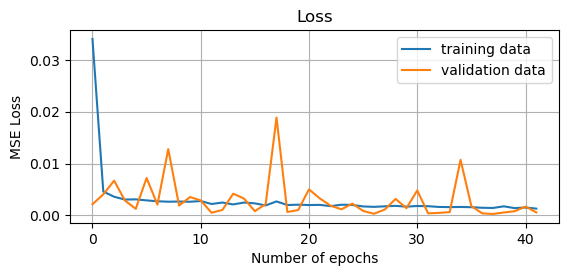

5544/5544 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step
Test RMSE: 0.018
acc: 99.985275
R² score: 0.9996671080589294


In [14]:
look_loss(history)
best_model1 = tf.keras.models.load_model('layer1/CNN_model_layer1_st_no.h5')
all_estimate(best_model1,x_test, y_test)#x_test[:,:,:,0:5], x_test[:,:,:,5:8], y_test

In [15]:
# 模型预测
result = [] 

best_model = tf.keras.models.load_model('layer1/CNN_model_layer1_st_no.h5')
testPred = best_model.predict(x_test)
result.append(testPred)

result = np.array(result)
result = result.reshape(-1,1)

y_test = y_test.reshape(-1,1)
predict_layer1_st = scaler_l.inverse_transform(result)
y_test_layer1_unscaled = scaler_l.inverse_transform(y_test)


5544/5544 ━━━━━━━━━━━━━━━━━━━━ 50s 9ms/step


In [16]:
r2 = r2_score(y_test_layer1_unscaled[:,0],predict_layer1_st[:,0])
print('layer1 R² score:',r2)

mae =  np.mean(np.sqrt(np.square(y_test_layer1_unscaled[:,0]-predict_layer1_st[:,0])))
print('layer1 Test mae: %.3f' % mae)

layer1 R² score: 0.9996671080589294
layer1 Test mae: 0.057


Results written to results.txt
[[27.78527069 27.80954933 27.83905792 ... 27.10875511 27.1255722
  27.1541729 ]
 [27.77444267 27.80053329 27.82847404 ... 27.06218529 27.07909393
  27.10986328]
 [27.77342415 27.79649734 27.81740952 ... 27.00868797 27.02632713
  27.05892754]
 ...
 [12.87452507 12.86163902 12.51269913 ... 14.14918804 14.21912956
  14.20781231]
 [13.05238914 12.74386311 12.75817204 ... 13.49281788 13.58344269
  13.5307045 ]
 [        nan         nan 11.77506065 ... 12.24016476 12.18866634
  11.99499607]]


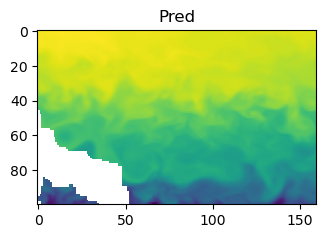

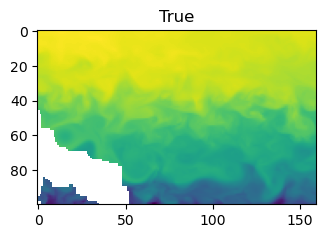

[[27.7201767  27.7436142  27.76192474 ... 27.11590958 27.12909317
  27.15399551]
 [27.70186424 27.72530365 27.74727631 ... 27.06756783 27.08807755
  27.11883926]
 [27.71065331 27.73189545 27.74727631 ... 27.01922607 27.03753662
  27.07635689]
 ...
 [12.85229015 12.92700005 12.60838604 ... 14.20511436 14.24832916
  14.23514557]
 [13.27491093 12.58787727 12.82665443 ... 13.52101135 13.61037064
  13.54957771]
 [        nan         nan 11.8048954  ... 12.30881691 12.24582672
  12.09201336]]


8916

In [17]:
predict_data = np.zeros((12, 16000, 1 ))  # out_data_reshape 的当前形状
true_data = np.zeros((12, 16000, 1 ) )
non_nan_mask = np.broadcast_to(combined_mask, (12, 16000))
predict_data[non_nan_mask] = predict_layer1_st
true_data[non_nan_mask] = y_test_layer1_unscaled

predict_data[predict_data == 0] = np.nan
true_data[true_data == 0] = np.nan
# 打开一个文件并写入内容
with open("./layer1/results.txt", "w") as file:
    file.write(f"layer1 R² score: {r2}\n")
    file.write(f"layer1 Test mse: {mae:.3f}\n")

print("Results written to results.txt")

predict_data = predict_data.reshape(12,100,-1,1)
true_data = true_data.reshape(12,100,-1,1)

np.save(r'./layer1/predict_data.npy',predict_data)
np.save(r'./layer1/true_data.npy',true_data)

plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(predict_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('Pred')
print(predict_data[0,:,:,0])
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/testPred_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执
plt.show()
plt.figure(figsize=(3.6, 3.6), dpi = 100)
plt.imshow(true_data[0,:,:,0])              #执行这一行后并不会立即看到图像，这一行更像是将depthmap载入到plt里
plt.title('True')
# plt.savefig('D:/Postgra/South_Ocean/Conv3D+LSTM/model5_18/y_test_with_nan5_18.jpg')       #执行后可以将文件保存为jpg格式图像，可以双击直接查看。也可以不执行
plt.show()
print(true_data[0,:,:,0])

gc.collect()